In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/datasets/img_align_celeba.zip" 

Streaming output truncated to the last 5000 lines.
  inflating: img_align_celeba/197600.jpg  
  inflating: img_align_celeba/197601.jpg  
  inflating: img_align_celeba/197602.jpg  
  inflating: img_align_celeba/197603.jpg  
  inflating: img_align_celeba/197604.jpg  
  inflating: img_align_celeba/197605.jpg  
  inflating: img_align_celeba/197606.jpg  
  inflating: img_align_celeba/197607.jpg  
  inflating: img_align_celeba/197608.jpg  
  inflating: img_align_celeba/197609.jpg  
  inflating: img_align_celeba/197610.jpg  
  inflating: img_align_celeba/197611.jpg  
  inflating: img_align_celeba/197612.jpg  
  inflating: img_align_celeba/197613.jpg  
  inflating: img_align_celeba/197614.jpg  
  inflating: img_align_celeba/197615.jpg  
  inflating: img_align_celeba/197616.jpg  
  inflating: img_align_celeba/197617.jpg  
  inflating: img_align_celeba/197618.jpg  
  inflating: img_align_celeba/197619.jpg  
  inflating: img_align_celeba/197620.jpg  
  inflating: img_align_celeba/197621.jpg  
  i

In [ ]:
!pip install wandb
!wandb login
#   d136db4e1c22c6659a9bbdee119442d4c564a007

     |████████████████████████████████| 1.8 MB 9.8 MB/s 
     |████████████████████████████████| 181 kB 70.2 MB/s 
     |████████████████████████████████| 144 kB 84.8 MB/s 
     |████████████████████████████████| 63 kB 2.1 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=2ac2b007d3c6963d71cf428f1c4de5b7aba1586d308cfe9b4179e7809535b2c6
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:

import tensorflow 
from numpy import zeros, ones, asarray
from numpy.random import randn, randint
import tensorflow as tf

from tensorflow.keras.datasets.cifar10 import load_data
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, Dropout, GaussianNoise, BatchNormalization
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt

from itertools import islice

import wandb
from wandb.keras import WandbCallback


import os
import pathlib
from google.colab import files




In [ ]:
dataset_directory = "/content/img_align_celeba/"
BATCH_SIZE = 128
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_directory, label_mode=None, image_size=(178, 218), batch_size=BATCH_SIZE,
) #3min

dataset = dataset.map(lambda x: x / 255.0)
dataset = dataset.map(lambda x: x*2 -1)
dataset = dataset.map(lambda x : tensorflow.image.resize(x, (112,128)))

Found 202599 files belonging to 1 classes.


In [ ]:
#(trainX, trainy), (testX, testy) = tensorflow.keras.datasets.cifar10.load_data()
# plot 25 images
#print(dataset)

#for i, image in enumerate(islice(dataset,0,25)):
#	if i<25 :
#		plt.subplot(5, 5, 1 + i)
#		plt.axis('off')
#		plt.imshow(image)
#plt.show()

In [ ]:

def define_discriminator(in_shape=(112,128,3)) :
  model = Sequential()
  model.add(GaussianNoise(0.01, input_shape=in_shape))
  model.add(Conv2D(128, (3,3), strides=(2,2), padding = 'same'))
  #model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.2))

  model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Flatten())
  model.add(Dropout(0.4))
  model.add(Dense(1,activation="sigmoid"))

  #Compile model
  opt = Adam(learning_rate=0.0002, beta_1=0.5)
  model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

  return model

test_discr = define_discriminator()
print(test_discr.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gaussian_noise (GaussianNoi  (None, 112, 128, 3)      0         
 se)                                                             
                                                                 
 conv2d (Conv2D)             (None, 56, 64, 128)       3584      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 56, 64, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 32, 128)       147584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 28, 32, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 16, 128)       147584    
                                                        

In [ ]:
def define_generator(latent_dim):    #latent_dim is the dimension of the latent vector (e.g., 100)
	model = Sequential()
	# We will reshape input latent vector into 8x8 image as a starting point. 
    #So n_nodes for the Dense layer can be 128x8x8 so when we reshape the output 
    #it would be 8x8x128 and that can be slowly upscaled to 32x32 image for output.
	n_nodes = 128 * 14 * 16  
	model.add(Dense(n_nodes, input_dim=latent_dim)) #Dense layer so we can work with 1D latent vector
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((14, 16, 128)))  #8x8x128 dataset from the latent vector. 
	# upsample to 16x16
	model.add(Conv2DTranspose(64, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
 
	model.add(Conv2DTranspose(64, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
 
	# upsample to 32x32
	model.add(Conv2DTranspose(64, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# generate
	model.add(Conv2D(3, (8,8), activation='tanh', padding='same'))
	return model  #Model not compiled as it is not directly trained like the discriminator.
                    #Generator is trained via GAN combined model. 

test_gen = define_generator(100)
print(test_gen.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 28672)             2895872   
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 28672)             0         
                                                                 
 reshape (Reshape)           (None, 14, 16, 128)       0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 28, 32, 64)       131136    
 nspose)                                                         
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 28, 32, 64)        0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 56, 64, 64)       65600     
 ranspose)                                            

In [ ]:
# define the combined generator and discriminator model, for updating the generator
#Discriminator is trained separately so here only generator will be trained by keeping
#the discriminator constant. 
def define_gan(generator, discriminator):
	discriminator.trainable = False  #Discriminator is trained separately. So set to not trainable.
	# connect generator and discriminator
	model = Sequential()
	model.add(generator)
	model.add(discriminator)
	# compile model
	opt = Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model


In [ ]:
def save(gan, generator, discriminator, path):
    discriminator.trainable = False
    save_model(gan, path+'gan')
    discriminator.trainable = True
    save_model(generator, path+'generator')
    save_model(discriminator, path+'discriminator')


def load(path):
    discriminator = load_model(path+'discriminator')
    generator = load_model(path+'generator')
    gan = load_model(path+'gan')
    gan.summary()
    discriminator.summary()
    generator.summary()

    return gan, generator, discriminator

In [ ]:
# pick a batch of random real samples to train the GAN
#In fact, we will train the GAN on a half batch of real images and another 
#half batch of fake images. 
#For each real image we assign a label 1 and for fake we assign label 0. 

def generate_real_samples(batch, n_samples):
	# choose random images
	X = asarray(list(batch))
	y = ones((n_samples, 1))
	return X, y


# generate n_samples number of latent vectors as input for the generator

def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# use the generator to generate n fake examples, with class labels
#Supply the generator, latent_dim and number of samples as input.
#Use the above latent point generator to generate latent points. 

def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict using generator to generate fake samples. 
	X = generator.predict(x_input)
	# Class labels will be 0 as these samples are fake. 
	y = zeros((n_samples, 1))  #Label=0 indicating they are fake
	return X, y

In [ ]:
# train the generator and discriminator
#We loop through a number of epochs to train our Discriminator by first selecting
#a random batch of images from our true/real dataset.
#Then, generating a set of images using the generator. 
#Feed both set of images into the Discriminator. 
#Finally, set the loss parameters for both the real and fake images, as well as the combined loss. 

def train(g_model, d_model, gan_model, dataset, latent_dim, n_batch, n_epochs=100, verbose=2, previous_epoch = 0):
	bat_per_epo = int(len(dataset))
	if previous_epoch != 0 :
		gan_model, g_model, d_model = load("drive/MyDrive/Models/15-04")
	# manually enumerate epochs and bacthes. 
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j, batch in enumerate(dataset):
            
            # Train the discriminator on real and fake images, separately (half batch each)
        #Research showed that separate training is more effective. 
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(batch, len(batch))
			# update discriminator model weights
            ##train_on_batch allows you to update weights based on a collection 
            #of samples you provide
            #Let us just capture loss and ignore accuracy value (2nd output below)
			d_loss_real, _ = d_model.train_on_batch(X_real, y_real) 

            # generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_batch)
			# update discriminator model weights
			d_loss_fake, _ = d_model.train_on_batch(X_fake, y_fake)
			      
            #d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) #Average loss if you want to report single..
            
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch*2)
             
            # The generator wants the discriminator to label the generated samples
        # as valid (ones)
        #This is where the generator is trying to trick discriminator into believing
        #the generated image is true (hence value of 1 for y)			
			y_gan = ones((n_batch*2, 1))
            
            # Generator is part of combined model where it got directly linked with the discriminator
        # Train the generator with latent_dim as x and 1 as y. 
        # Again, 1 as the output as it is adversarial and if generator did a great
        #job of folling the discriminator then the output would be 1 (true)
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
		
			wandb.log({"g_loss": g_loss,
              "d_loss_real": d_loss_real,
              "d_loss_fake": d_loss_fake
   		})
            # Print losses on this batch
			if verbose == 2 :
				print('Epoch>%d, Batch %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss_real, d_loss_fake, g_loss))
	# save the generator model
	
		if verbose == 1 :
					print('Epoch>%d, d1=%.3f, d2=%.3f g=%.3f' %
					(i+1, bat_per_epo, d_loss_real, d_loss_fake, g_loss))
		save(gan_model, g_model, d_model, "drive/MyDrive/Models/15-04")


In [ ]:
#Train the GAN

# size of the latent space
latent_dim = 256
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# load image data
dataset = dataset
# train model
previous_epoch = 0
wandb.init(project="my-test-project", entity="alexauragan")

train(generator, discriminator, gan_model, dataset, latent_dim,n_batch=BATCH_SIZE, n_epochs=20, previous_epoch = previous_epoch)

NameError: ignored

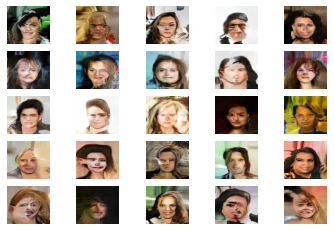

In [ ]:
from numpy.random import randn


# Plot generated images 
def show_plot(examples, n):
	for i in range(n * n):
		plt.subplot(n, n, 1 + i)
		plt.axis('off')
		plt.imshow(examples[i, :, :, :])
	plt.show()

# load model
model = load_model("drive/MyDrive/Models/15-04generator") #Model trained for 100 epochs
# generate images
latent_points = generate_latent_points(latent_dim, 25)  #Latent dim and n_samples
# generate images
X = model.predict(latent_points)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0

import numpy as np
X = (X*255).astype(np.uint8)

# plot the result
show_plot(X, 5)

#Note: CIFAR10 classes are: airplane, automobile, bird, cat, deer, dog, frog, horse,
# ship, truck
